# Peng's updated Kristjan's Bandit Algorithm for HS2

In [1]:
#Imports

%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm
import pickle
import itertools


C:\Users\isaac\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#A bandit model, consisting of reward coefficient mean and covariance

# From Peng's 2-1 algorithm; action-centered bandit (algorithm 2)


class model:
    def __init__(self,mu,Sigma):
        self.mu = mu
        self.Sigma = Sigma
        

#THE BANDIT CODE (in class form)

class ContextBandit:
    #Bandit Object
    def __init__(self,nInteract, pc_params,prior_model, gamma, fc_params, f_baseline, f_interact, sigma2 = 1., prior_weight = 1.):
        '''
        pc_params: (pi_min, pi_max) parameters for probability clipping
        prior_model: prior Gaussian model with \mu_\beta, \Sigma_\beta
        gamma: gamma for GP Prior
        fc_params: feedback controller parameters: (\lambda_c, N_c, T_c)
            T_c: maximum number of decision times to count dosage
        f_baseline: baseline feature mapping; f: S \to R^p_1
        f_interact: interaction feature mapping; f_interact: S' \to R^p_2
        sigma2: reward noise estimate (variance)
        prior_weight: how much to weigh prior, set to 1 for full weight
        '''
        #initialize input parameters
        self.nInteract = nInteract
        self.pi_min = pc_params[0]
        self.pi_max = pc_params[1]
        self.gamma = gamma
        self.sigma2 = sigma2

        self.f_baseline = f_baseline
        self.f_interact = f_interact

        self.lambda_c = fc_params[0]
        self.N_c = fc_params[1]
        self.T_c = fc_params[2]

        # self.v = 1e-1 #tuning parameter - multiplier on bandit prior covariances 

        
        #Initialize model to prior data model
        # Mean = prior_weight * prior_model.mu,
        # Cov = I_n + prior_weight * prior_model.Sigma
        
        self.prior_model = prior_model

        # This is mu and Sigma
        self.current_model = model(prior_weight*prior_model.mu,
            np.eye(len(prior_model.mu)) + prior_weight*prior_model.Sigma)
        # This is mu' and Sigma'
        self.daystart_model = model(prior_weight*prior_model.mu,
            np.eye(len(prior_model.mu)) + prior_weight*prior_model.Sigma)
        
    def process_context(self, I_T, S_T, N_t):
        '''
        Inputs context for a given decision point,
        updates the current day's model, and returns action probability alpha

        Line 20 of algorithm

        I_T: Current availability
        S_T: Current state
        N_t: Dosage over past T_c decision times; number of messages sent since present minus T_c
        Returns: alpha, probability of taking action 1
        '''
        if I_T == 1:
            current_model = self.current_model
            # Current Posterior mean and variance for interaction term
            mu2 = current_model.mu[1:1+self.nInteract]
            Sigma2 = current_model.Sigma[1:1+self.nInteract,1:1+self.nInteract]

            # Compute probability of unclipped randomization probability
            X_mean = self.f_interact(S_T).T.dot(mu2) - self.lambda_c*(N_t - self.N_c)*(N_t - self.N_c > 0)
            X_var = self.f_interact(S_T).dot(Sigma2.dot(self.f_interact(S_T).T))

            # Actual probability
            pi_t = 1 - norm.cdf(0, X_mean, np.sqrt(X_var))

            if pi_t < self.pi_min:
                alpha = self.pi_min
            elif pi_t > self.pi_max:
                alpha = self.pi_max
            else: 
                alpha = pi_t
            # print(mean, variance, alpha)

        else:
            alpha = 0

        # Update current model to posterior of Gaussian Process
        self.current_model.mu = (1-self.gamma)*self.prior_model.mu + self.gamma * self.current_model.mu
        self.current_model.Sigma = (1 - self.gamma ** 2.) * self.prior_model.Sigma + (self.gamma ** 2.) * self.current_model.Sigma 

            
        return alpha #probability of taking action 1

        
    ######
    
    def update_model(self, S_T, R_T, A_T, pi_T, I_T, t = 5):
        # Update at end of day
        '''
        At end of day, updates the model given the 
        S_T: states for day T
        R_T: rewards for day T
        A_T: actions for day T
        pi_T: probabilities of action 1 for day T
        I_T: availability for each time point on day T
        t: number of decision points per day, defaults to 5
        '''

        # Set aliases for the current model
        current_model = self.current_model
        current_model.mu = self.daystart_model.mu
        current_model.Sigma = self.daystart_model.Sigma

        for dpt in range(t):
            # If available then:
            if I_T[dpt]:
                f_t = np.concatenate([self.f_baseline(S_T[dpt]), (A_T[dpt] - pi_T[dpt]) * self.f_interact(S_T[dpt])], axis=0)
            
                
                Sigma_dot_f_t = np.expand_dims(current_model.Sigma.dot(f_t),1)
                denom = self.sigma2 + f_t.T.dot(Sigma_dot_f_t)
                beta = current_model.mu + (R_T[dpt] - f_t.T.dot(current_model.mu)) / denom * Sigma_dot_f_t
                Omega = current_model.Sigma - 1. / denom * Sigma_dot_f_t.dot(Sigma_dot_f_t.T)
                current_model.mu = self.gamma * beta           + (1 - self.gamma) * self.prior_model.mu
                current_model.Sigma = (self.gamma ** 2.) * Omega + (1 - self.gamma ** 2.) * self.prior_model.Sigma
                



        
        # New day, new model

        self.daystart_model.mu = current_model.mu.copy()
        self.daystart_model.Sigma = current_model.Sigma.copy()
        
########


In [3]:
# HS Analysis Functions

### Aux Functions for reading two different .csv files ###
def read_hs1(yoozer, hs1_file = "../../../Data/suggest-analysis-kristjan.csv"):
    pd_df = pd.read_csv(hs1_file) #'suggest-analysis-kristjan.csv')
    pdf = pd_df[:179]
    snda = pd_df['send.active'] == 1
    snd = pd_df['send'] == 0
    usr = pd_df['user'] == yoozer
    ddf = pd_df[(snda | snd) & usr]
    ddf = ddf.reset_index(drop=True)
    
    
    return ddf,pd_df

def read_hs1_gf(yoozer, hs1_gf_file = '../../../Data/suggest-kristjan.csv'):
    pd_df = pd.read_csv(hs1_gf_file) #'suggest-analysis-kristjan.csv')
    pdf = pd_df[:179]
    snda = pd_df['send.active'] == 1
    snd = pd_df['send'] == 0
    usr = pd_df['user'] == yoozer
    ddf = pd_df[(snda | snd) & usr]
    ddf = ddf.reset_index(drop=True)

    return ddf,pd_df


def nan_equal(a,b):
    return ((a == b) | (np.isnan(a) & np.isnan(b))).all()

def read_data(N, T, t, nBaseline):
    ### Read in Feature vector, Reward Vector, and Action Vector for each user ###
    # Also Standardizes all features

    max_yoozer = N+1

    featVec = np.empty((max_yoozer,T*t, nBaseline))
    featVec.fill(np.nan)

    rewardVec = np.empty((max_yoozer,T*t))
    rewardVec.fill(np.nan)

    actionVec = np.empty((max_yoozer,T*t))
    actionVec.fill(np.nan)

    # Bias term

    for yoozer in range(1,max_yoozer):
    #     print("Processeing User: ", yoozer)

        ddf,pd_df = read_hs1(yoozer)
        #Make features
        #Center and scale
        decision_ind = ddf['decision.index.nogap']
        reward_h = ddf['jbsteps30.log']
        send_any = ddf['send']
        send_active = ddf['send.active']

        assert np.all(send_any == send_active)

        #total_sent = ddf['totalSent']
        # Study day index
        dazze = ddf['study.day.nogap']

        # Number of messages sent in last week
        day_ind  = (ddf['study.day.nogap'] - np.mean(pd_df['study.day.nogap']))/np.std(pd_df['study.day.nogap'])#Number sent in last whatever
        #Add feature for # of week period (hsteps v2) WATCH OUT FOR COLINEARITY WITH INTERCEPT

        # Ohter location indicator
        loc_ind = ddf['loc.is.other']

        # Std deviation of step count in last 7 days
        steps_sd = (ddf['window7.steps60.sd'] - np.mean(pd_df['window7.steps60.sd']))/np.std(pd_df['window7.steps60.sd'])

        # Step count in previous 30 minutes
        state = (ddf['jbsteps30pre.log'] - np.mean(pd_df['jbsteps30pre.log']))/np.std(pd_df['jbsteps30pre.log'])

        # Work location indicator
        #wrk_ind = ddf['location.category'], #loc_ind = ddf['location.category']
        wrk_ind = ddf['loc.is.work'] #compare to string “work”

        # Square root steps yesterday
        steps_yest = (ddf['steps.yesterday.sqrt'] - np.mean(pd_df['steps.yesterday.sqrt']))/np.std(pd_df['steps.yesterday.sqrt'])

        # Temperature, set -1024 as 0
        temp = (ddf['temperature'] - np.mean(pd_df['temperature']))/np.std(pd_df['temperature'])
        temp[ddf['temperature'] == -1024] = 0

        ddfgf,pd_dfgf = read_hs1_gf(yoozer)

        # ?? Unclear what this is
        # Reward: Step count in 30 minutes following decision point
        steps_gf = (np.log(ddfgf['gfsteps30pre'] + .5) - np.mean(np.log(pd_dfgf['gfsteps30pre'] + .5))/np.std(np.log(pd_dfgf['gfsteps30pre']+.5)))

        end_ind = day_ind.shape[0]


        # Set reward, action, and state
        rewardVec[yoozer,:end_ind] = reward_h.astype(float)
        actionVec[yoozer,:end_ind] = send_any.astype(float)

        featVec[yoozer,:end_ind,0].fill(1) # Only fill rows with observations
        featVec[yoozer,:end_ind,1] = day_ind #study.day.nogap
        featVec[yoozer,:end_ind,2] = loc_ind.astype(int) # loc.is.other
        featVec[yoozer,:end_ind,3] = steps_sd.astype(float) # window7.steps60.sd
        featVec[yoozer,:end_ind,4] = state # jbsteps30pre.log
        featVec[yoozer,:end_ind,5] = wrk_ind.astype(int) # loc.is.work
        featVec[yoozer,:end_ind,6] = steps_yest # steps.yesterday.sqrt
        featVec[yoozer,:end_ind,7] = temp.astype(float) # temperature

        # This was included but didn't make too much sense
    #     featVec[yoozer,:end_ind,8] = steps_gf.astype(float)[:day_ind.shape[0]]
    
    ## TREAT DATA ##

    # Drop 0th user, since users are 1-indexed
    featVec = featVec[1:,:,:].copy()
    rewardVec = rewardVec[1:,:].copy()
    actionVec = actionVec[1:,:].copy()

    # Reshape actionVec to have additional 1 dim
    actionVec = actionVec.reshape(actionVec.shape[0],actionVec.shape[1],1)

    # Mean impute featVec where there is an observation
    featVec[~np.isnan(featVec[:,:,1])] = np.nan_to_num(featVec[~np.isnan(featVec[:,:,1])])
    
    return featVec, rewardVec, actionVec

def resid_regression(N, T, t, nBaseline, rewardVec, actionVec, featVec):
    '''Perform Regression on Pooled R ~ A*S' + S to create Residuals'''
    # Actual Dimensions of A and S
    a_dim = 1
    s_dim = nBaseline

    # Copy for notational ease
    R = rewardVec.copy()
    A = actionVec.copy()
    S = featVec.copy()


    # Fit OLS r ~ (a_t s'_t, s_t)^T \eta, where s' are interact terms and s are all baseline
    resid_model = sm.OLS(endog = R.reshape(N*T*t), exog = np.concatenate([(A * S[:,:,1:1+nInteract]), S], 2).reshape((N*T*t,(nInteract + nBaseline))), missing = "drop")
    resids_unproc = resid_model.fit().resid

    # Parameters
    Etas_fit = resid_model.fit().params


    ## Fill resids ##

    # Copy shape and location of nans
    resids = rewardVec.copy()

    curr_ind = 0
    for n in range(N):

        old_ind = curr_ind
        curr_ind += R[n][~np.isnan(R[n])].shape[0]

        # Copy in indices
        resids[n][:curr_ind-old_ind] = resids_unproc[old_ind:curr_ind]
    
    return resids, Etas_fit


# # Code to Generate Simulated Users
def generate_new_users(resids, A, S, N_new, T_new, T, t, users_to_sample = 10):
    '''
    Generates new random user
    
    Inputs:
        resids: Residuals
        A: Actions
        S: States
        N_new: Int of number of new users to generate from sampling
        T_new: Int of number of days for each new user
    
    Returns:
        resids_new: Matrix of resids for sampled users
        A_new: Matrix of associated actions for sampled users
        S_new: Matrix of associated states for sampled users
        
    *Assumes shapes:
      resids: (N, T * t) 
      A: (N, T * t, )
    '''
    
    # Obtain original dimensions of data from actions A
    N = A.shape[0]

    # Component dims of A and S 
    a_dim = A.shape[2]
    s_dim = S.shape[2]

    # Sample random users from original data
    sampled_user_indices = np.empty((N_new, users_to_sample)).astype(int)

    # Loop to reset sampling without replacement for each new user
    for i in range(N_new):
        sampled_user_indices[i] = np.random.choice(N, size = users_to_sample, replace = False)
    
    # Concatenate resids, A, and S to ensure processing is uniform
    concat_data = np.concatenate([np.expand_dims(resids,2),A,S], axis = 2)
    sampled_users_untreated = np.take(concat_data, sampled_user_indices, 0).reshape(N_new, users_to_sample * T*t, 1 + a_dim + s_dim)
    sampled_users = np.empty((N_new, T_new * t, 1 + a_dim + s_dim))
    
    for i in range(N_new):
        
        # Cast to DataFrame to dropna, reset index to shift datapoints up to be consecutive, takes T_new * t datapoints
        sampled_users[i] = pd.DataFrame(sampled_users_untreated[i]).apply(lambda col: col.dropna().reset_index().iloc[:,-1], axis = 0).as_matrix()[:T_new * t]
        
    # Sampled Generated residuals
    resids_new = sampled_users[:,:,0].reshape(N_new, T_new, t)
    # Sampled actions
    A_new = sampled_users[:,:,1:(1+a_dim)].reshape(N_new, T_new, t, a_dim)
    # Sampled states
    S_new = sampled_users[:,:,(1+a_dim):].reshape(N_new, T_new, t, s_dim)
    
    return resids_new, A_new, S_new



# def reward_func(resid, a, s, Eta, nInteract = 3):
#     '''Basic reward function, can edit for different generative models.
#     Works for multidimensional eta, a, and s, so long as they are of same multidimension.
#     Assumes s has first element as bias for the regression.'''
#     return(resid + np.concatenate([a * np.take(s,range(1,1+nInteract),-1), s], a.ndim-1).dot(Eta))


#Create a reward function from true coefficients, with residuals non-mandatory
def reward_func(S,A,coef0,coef1, resid = None, single_dim = True):
    '''Basic reward function, can edit for different generative models.
    Works for multidimensional eta, a, and s, so long as they are of same multidimension.
    Assumes s has first element as bias for the regression.
    
    Resid must be passed in if not single dim.
    If single dim, can speed out without np.take.'''
    
    nInteract = len(coef1)
    
    if single_dim:
        predictors = np.concatenate([A * S[1:1+nInteract], S], 0)
    else:
        predictors = np.concatenate([A * np.take(S,range(1,1+nInteract),-1), S], 0)
    
    Eta = np.concatenate([coef1, coef0])
    
    if resid is None:
        resid = 0
        
    return(resid + np.dot(predictors, Eta))


def k_fold_split(S, R, A, k = 5):
    '''
    Split S,R,A into k fold train/test batches of roughly size N/k
    '''
    combined = np.copy(np.concatenate([S,np.expand_dims(R,-1),A],axis=-1))
    np.random.shuffle(combined) # Shuffle all together
    N = combined.shape[0]

    tests = []
    trains = []
    
    for i in range(k):
        # For each N/k sized batch, return test and train
        tests.append(combined[int(i*(N/k)):int((i+1)*(N/k))])
        trains.append(np.concatenate([combined[:int(i*(N/k))], combined[int((i+1)*(N/k)):]]))
    
    train_zip = []
    test_zip = []
    
    # Separate back to (S,R,A)
    for train in trains:
        train_zip.append((train[:,:,:S.shape[-1]], train[:,:,S.shape[-1]:1+S.shape[-1]], train[:,:,S.shape[-1]+1:]))
    for test in tests:
        test_zip.append((test[:,:,:S.shape[-1]], test[:,:,S.shape[-1]:1+S.shape[-1]], test[:,:,S.shape[-1]+1:]))
        
    return train_zip, test_zip

In [4]:
## Creating Simulations

# Counts from HS 1
N = 48
T = 41
t = 5
nBaseline = 1+7
nInteract = 3 # Add 1 for bias term

N_new = 55
T_new = 90

S, R, A = read_data(N, T, t, nBaseline)
resids, Etas_fit = resid_regression(N, T, t, nBaseline, R, A, S)
resids_new, A_new, S_new = generate_new_users(resids, A, S, N_new, T_new, T, t)
I_new = np.ones_like(A_new)


C:\Users\isaac\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: DtypeWarning: Columns (15,16,18,60,61,96,97,112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Checklist #
1)  Split
2)  Train
3)  Optimize
(Run )
3)  Validate

## Compute quality metrics ##

1. Plot time series of $\pi_t(1 | S_t)$ for all $t$, for some users.
2.	Examine probs i.e. $\pi_t(1 | S_t)$ vs. $opt_t(S_t)$, for all $t$, for some users.
    a.	$opt_t(S_t) = 0.8\{\text{optimal action is 1 in context } S_t\} + 0.2 \{\text{optimal action is 0 in context } S_t\}$
3.	Examine $|\pi_t(1 | S_t) - opt_t(S_t)|$ for all users, averaging over all N users for each time point $t$.
4.	Examine $|\pi_t(1 | S_t) - opt_t(S_t)|$ for all users, histogram of each user's mean.
5.	Examine cumulative regret over $t$

    a.  Plot average over all users
    
    b.  Plot time series for individual users
    
    c.	Regret = Expected reward of bandit - reward of optimal policy
    
6.	Compute number of actions taken each $t$

    a.	Plot histogram across all days for each of several simulated users
    
    b.	Average number of actions taken across all $N$ users, plot average versus $t$



In [5]:
# VARIABLES FROM ABOVE CELL

S_new # Baseline States for simulated users
resids_new # Residuals; note this does not match up with Kristjan's Eta definition (he treats this as baseline OLS coefficient)

# Etas[0:3] is action*interact features
# Etas[3] is state bias (1's)
# Etas[4:11] are baseline features
Etas_fit

array([-0.21181203, -0.16692167,  0.08116949,  3.04487594, -0.02305797,
        0.06443497,  0.18900795,  1.36208089,  0.30135504,  0.23107337,
        0.38301622])

In [6]:
#A simulation of above standard model.

def f_baseline(featVec):
    return featVec

def f_interact(featVec):
    return featVec[1:1+3]


def run_simulation(coef0, coef1, S_sim, I_sim, resids_sim, reward_func, prior_model,
                   fc_params, nInteract = 3, nBaseline = 7+1, pc_params = [.2, .8],
                   f_baseline = f_baseline, f_interact = f_interact,
                   gamma = 1., sigma2 = 1. , T = 90, t = 5, no_resid_flag = False):
    '''
    coef0: Reward coefficients for baseline (PHI), first element is bias term
    coef1: Reward coefficients for interaction (THETA); note that concatenated, [THETA, PHI] = Eta
    S_sim: simulated states
    I_sim: simulated availabilities; 1 = available, 0 = unavailable
    resids_sim: Residuals of simulated users
    reward_func: reward function, must have type reward(featVec, action, coef0, coef1, resid)
    nInteract: Number of interaction features
    nBaseline: Number of baseline features
    params: Bandit parameters; [minprob, maxprob, priorweight]
    T: days of study
    t: decision points per day
    no_resid_flag: If True will substitute 0 for residuals, if False will use true residuals
    '''
    N = S_sim.shape[0]
    assert T == S_sim.shape[1]
    assert t == S_sim.shape[2]
    assert nBaseline == S_sim.shape[3]
    
    #creating variables for saving history of what we do
    regret = np.empty((N, T, t))
    prob  = np.empty((N, T, t))
    action = np.empty((N, T, t))
    opt = np.empty((N, T, t))
    regret.fill(np.nan)
    prob.fill(np.nan)
    action.fill(np.nan)
    opt.fill(np.nan)
    
    # Containers for bandit parameters
    bandit_covs = np.empty((N, T,t, nInteract+nBaseline, nInteract+nBaseline))
    bandit_covs.fill(np.nan)
    bandit_means = np.empty((N, T,t, nInteract+nBaseline))
    bandit_means.fill(np.nan)

    for sim_user_index in range(N):

        #Create a bandit object for each user
        bandit = ContextBandit(nInteract, pc_params, prior_model, gamma, fc_params, f_baseline, f_interact, sigma2) #Create and initialize bandit

        #Cycle thru days
        for day in range(T):

            rwd = np.zeros(t)
            featVec = np.zeros((nBaseline,t))
            #Cycle thru decision points in each day
            for dpt in range(t):
                #Generate random state vector 
                featVec[:,dpt] = S_sim[sim_user_index, day, dpt]
                user_resid = resids_sim[sim_user_index, day, dpt]
                if no_resid_flag:
                    user_resid = 0
                    
                #Get action probability from bandit
                
                # prob[] is the probability of taking action 1 at current decision point, i.e. \pi_t(1|s_t) in the doc (Quality metrics 1&2).
                # featInteract = S_sim[sim_user_index, day, dpt, 1:1+nInteract] #only use the interaction features, but first element is bias
                if False: #Do nothing
                    prob[sim_user_index, day, dpt] = 0
                else: #Use bandit
                    # Count dosage from previous N_c days
                    N_t = np.sum(action[sim_user_index].reshape(-1)[max(0,day*t + dpt - bandit.N_c):day*t + dpt])
                    # Compute clipped probability
                    prob[sim_user_index, day, dpt] = bandit.process_context(
                    I_sim[sim_user_index, day, dpt], S_sim[sim_user_index, day, dpt], N_t)


                #Choose action based on probability, i.e. do the randomization
                if np.random.rand() < prob[sim_user_index, day, dpt]:
                    action[sim_user_index, day, dpt] = 1
                else:
                    action[sim_user_index, day, dpt] = 0

                #Receive reward from the universe. 
                rwd[dpt] = reward_func(S_sim[sim_user_index, day, dpt], action[sim_user_index, day, dpt], coef0, coef1, user_resid)
                rwd[dpt] = reward_func(S_sim[sim_user_index, day, dpt], action[sim_user_index, day, dpt], coef0, coef1, user_resid)


                #What was expected regret given probability chosen by bandit?
                #(easy to do since we know the \theta coefficients, reward under action 1 is reward under action 0 plus \theta^T s_t, and vice versa)
                rwd0 = reward_func(S_sim[sim_user_index, day, dpt], 0, coef0, coef1, user_resid) # do we want to include user_resid here or use default 0?
                rwd1 = reward_func(S_sim[sim_user_index, day, dpt], 1, coef0, coef1, user_resid)

                #Expected reward under bandit policy
                rwdExp = prob[sim_user_index, day, dpt]*rwd1 + (1-prob[sim_user_index, day, dpt])*rwd0

                #Regret is difference between optimal reward and the reward we got
                #"Optimal" reward is restricted based on the min/max allowed probabilities
                #ISAAC: THIS IS THE REGRET AT THE CURRENT DECISION POINT. Cumulative regret is formed by summing this up from time 0 to the current time.
                regret[sim_user_index, day, dpt] = max(pc_params[0]*rwd0 + pc_params[1]*rwd1, pc_params[0]*rwd1 + pc_params[1]*rwd0) - rwdExp


                # Record optimal probability; sometimes reward will be same between actions
                opt[sim_user_index, day, dpt] = 0.8 * (rwd[1] > rwd[0]) + 0.2 * (rwd[1] <= rwd[0])

            #Perform bandit updates at end of day
            for dpt in range(t):
                bandit_covs[sim_user_index, day, dpt] = bandit.daystart_model.Sigma
#                 print(bandit_means[sim_user_index, day, dpt].shape, bandit.daystart_model.mu.flatten().shape)
                bandit_means[sim_user_index, day, dpt] = bandit.daystart_model.mu.flatten()
                bandit.update_model(S_sim[sim_user_index, day], rwd, action[sim_user_index, day], prob[sim_user_index, day], I_sim[sim_user_index, day])
                #bandit.update_model(np.concatenate([[1],featVec[1:nInteract+1,dpt],featVec[1+nInteract:,]]),rwd[dpt],np.zeros(nInteract),action[sim_user_index, day, dpt],prob[sim_user_index, day, dpt])


    return regret.reshape((N,T*t)), prob.reshape((N,T*t)), action.reshape((N,T*t)), opt.reshape((N, T*t)), bandit_covs.reshape((N,T*t, nInteract+nBaseline,nInteract+nBaseline)), bandit_means.reshape((N,T*t, nInteract+nBaseline)), bandit


In [7]:
prior_mdl = model(np.zeros((nInteract+nBaseline,1)),np.eye(nInteract+nBaseline))
fc_params = [1., 5, 10]


regret, prob, action, opt, bandit_cov, bandit_mean, bandit = run_simulation(coef0 = Etas_fit[3:11], coef1 = Etas_fit[0:3], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, reward_func = reward_func, fc_params = fc_params, prior_model = prior_mdl, gamma = 0.8)

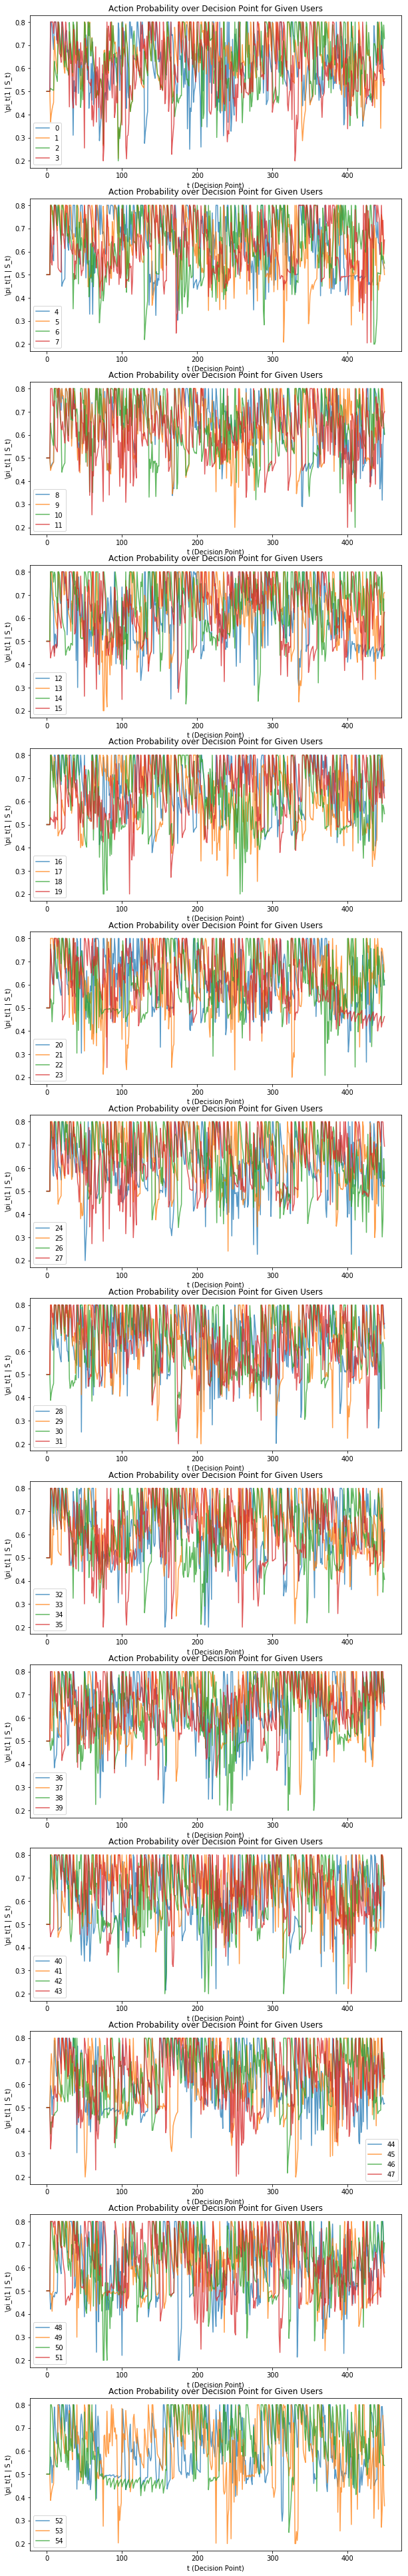

In [8]:
# QM 1
def plot_QM1(regret, prob, action, opt, y_size = 5, x_size = 10, num_show = 4, alpha = 0.75):
    ''' Time series of probs (\pi_t(1 | S_t)) for all t,
    for num_show users at a time
    '''
    N_new = prob.shape[0]
    num_plots = int(np.ceil(N_new/num_show))
    fig,ax = plt.subplots(num_plots, 1, figsize = (x_size, y_size*num_plots))
    for i in range(num_plots):
        pd.DataFrame(prob.T).iloc[:,int(i*num_show):int((i+1)*num_show)].plot(ax = ax[i], alpha = alpha)
        ax[i].set_title('Action Probability over Decision Point for Given Users')
        ax[i].set_ylabel('\pi_t(1 | S_t)')
        ax[i].set_xlabel('t (Decision Point)')
        
        
plot_QM1(regret, prob, action, opt)

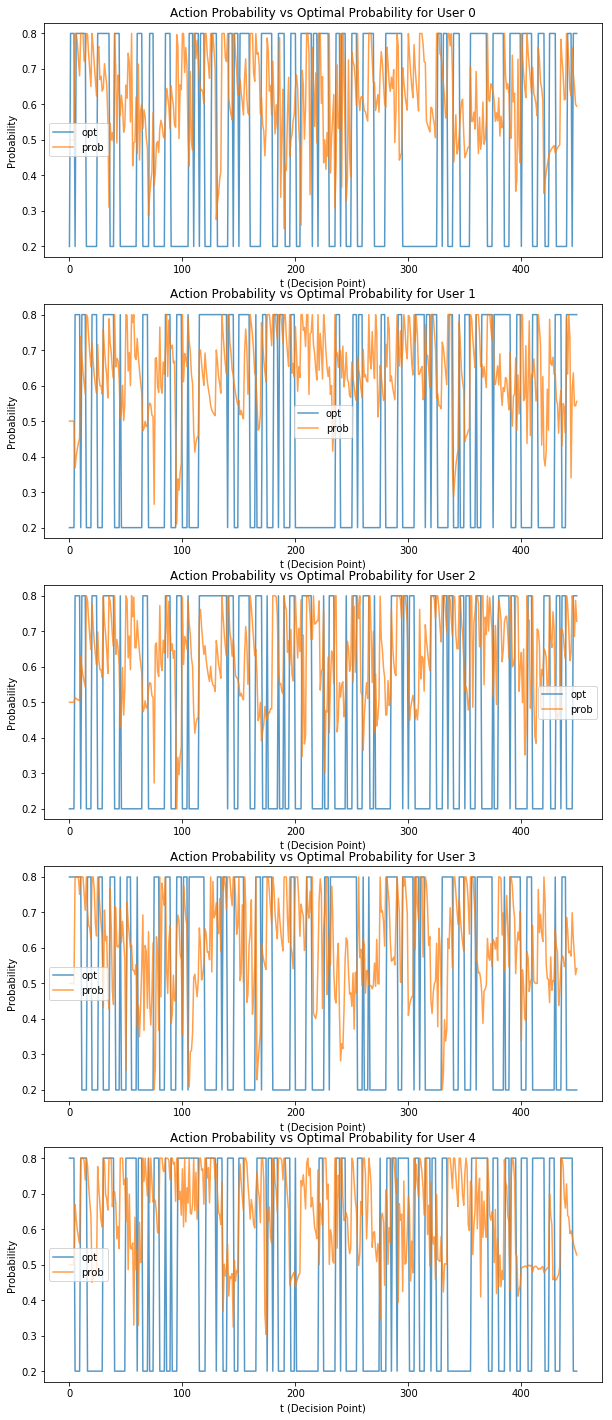

In [9]:
# QM 2
def plot_QM2(regret, prob, action, opt, y_size = 5, x_size = 10, user_inds_to_show = list(range(5)), alpha = 0.75):
    ''' Time series of probs (\pi_t(1 | S_t)) vs opt_t(S_t) for all t,
    for some users at a time
    
    opt_t(S_t) = 0.8{optimal action is 1 in context S_t} + 0.2 {optimal action is 0 in context S_t}
    '''
    N_new = prob.shape[0]
    num_plots = len(user_inds_to_show)
    fig,ax = plt.subplots(num_plots, 1, figsize = (x_size, y_size*num_plots))
    
    for user,i in zip(user_inds_to_show,range(N_new)):
        pd.DataFrame({"opt" : opt[i],"prob": prob[i]}).plot(ax = ax[i], alpha = alpha)
        ax[i].set_title('Action Probability vs Optimal Probability for User ' + str(user))
        ax[i].set_ylabel('Probability')
        ax[i].set_xlabel('t (Decision Point)')
        
        
plot_QM2(regret, prob, action, opt)

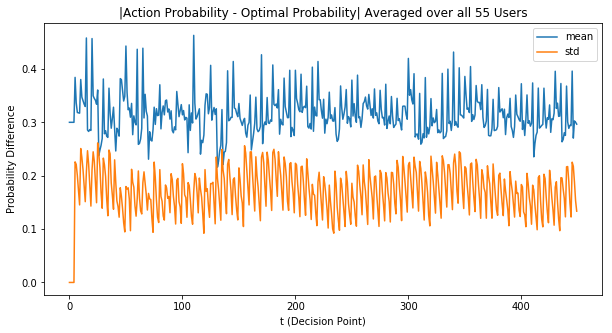

In [10]:
# QM 3
def plot_QM3(regret, prob, action, opt, y_size = 5, x_size = 10):
    ''' Time series of |probs (\pi_t(1 | S_t)) - opt_t(S_t)| for all t
    averaged over all users
    
    opt_t(S_t) = 0.8{optimal action is 1 in context S_t} + 0.2 {optimal action is 0 in context S_t}
    '''
    
    fig,ax = plt.subplots(1, 1, figsize = (x_size, y_size))
    
    pd.DataFrame({"mean": np.mean(np.abs(prob - opt),axis=0), "std": np.std(np.abs(prob - opt),axis=0)}).plot(ax = ax ) #, legend = False)
    ax.set_title('|Action Probability - Optimal Probability| Averaged over all ' + str(prob.shape[0]) + ' Users')
    ax.set_ylabel('Probability Difference')
    ax.set_xlabel('t (Decision Point)')

        
plot_QM3(regret, prob, action, opt)

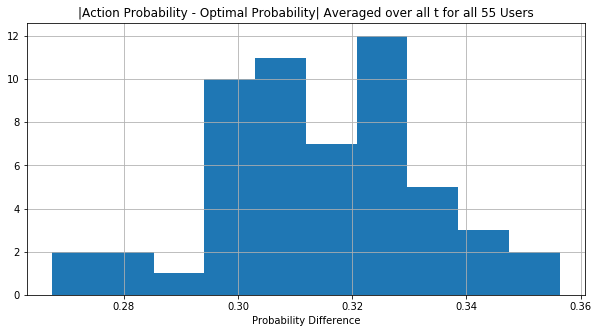

In [11]:
# QM 4
def plot_QM4(regret, prob, action, opt, y_size = 5, x_size = 10):
    ''' Histogram of |probs (\pi_t(1 | S_t)) - opt_t(S_t)| averaged over all t for all users
    averaged over all users
    
    opt_t(S_t) = 0.8{optimal action is 1 in context S_t} + 0.2 {optimal action is 0 in context S_t}
    '''
    fig,ax = plt.subplots(1, 1, figsize = (x_size, y_size))
    pd.DataFrame(np.mean(np.abs(prob - opt),axis=1))
    pd.DataFrame(np.mean(np.abs(prob - opt),axis=1)).hist(ax = ax)
    ax.set_title('|Action Probability - Optimal Probability| Averaged over all t for all ' + str(prob.shape[0]) + ' Users')
    ax.set_xlabel('Probability Difference')
    
plot_QM4(regret, prob, action, opt)

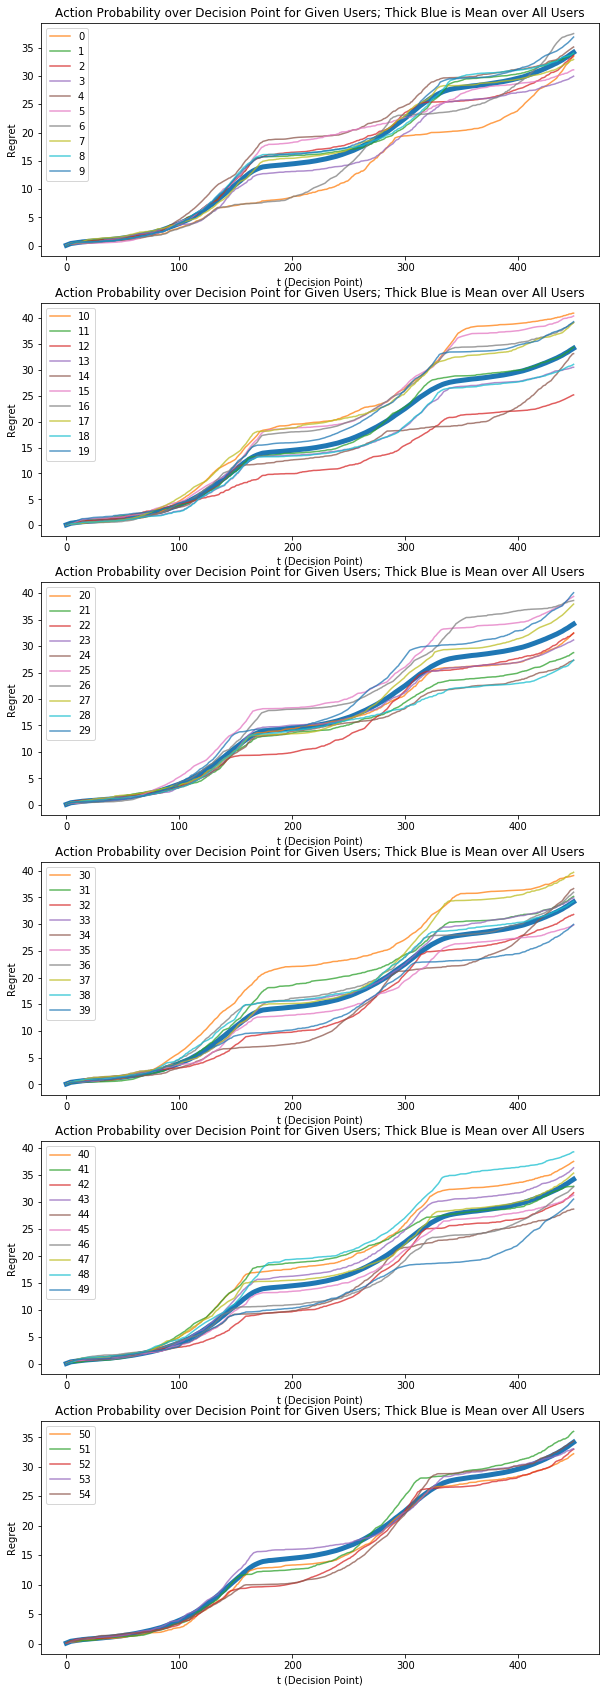

In [12]:
# QM 5
def plot_QM5(regret, prob, action, opt, y_size = 5, x_size = 10, num_show = 10, alpha = 0.75):
    ''' Time series of cumulative regret averaged over all t for all users
    '''
    N_new = regret.shape[0]
    num_plots = int(np.ceil(N_new/num_show))
    fig,ax = plt.subplots(num_plots, 1, figsize = (x_size, y_size*num_plots))
    df_out = pd.DataFrame(np.cumsum(regret,axis = 1).T)
    df_mean = np.mean(df_out,axis=1)
    df_mean.columns = ["Mean"]
    for i in range(num_plots):
        df_mean.plot(ax = ax[i], lw = 5)
        df_out.iloc[:,int(i*num_show):int((i+1)*num_show)].plot(ax = ax[i], alpha = alpha)
        ax[i].set_title('Action Probability over Decision Point for Given Users; Thick Blue is Mean over All Users')
        ax[i].set_ylabel('Regret')
        ax[i].set_xlabel('t (Decision Point)')
        
    
plot_QM5(regret, prob, action, opt)

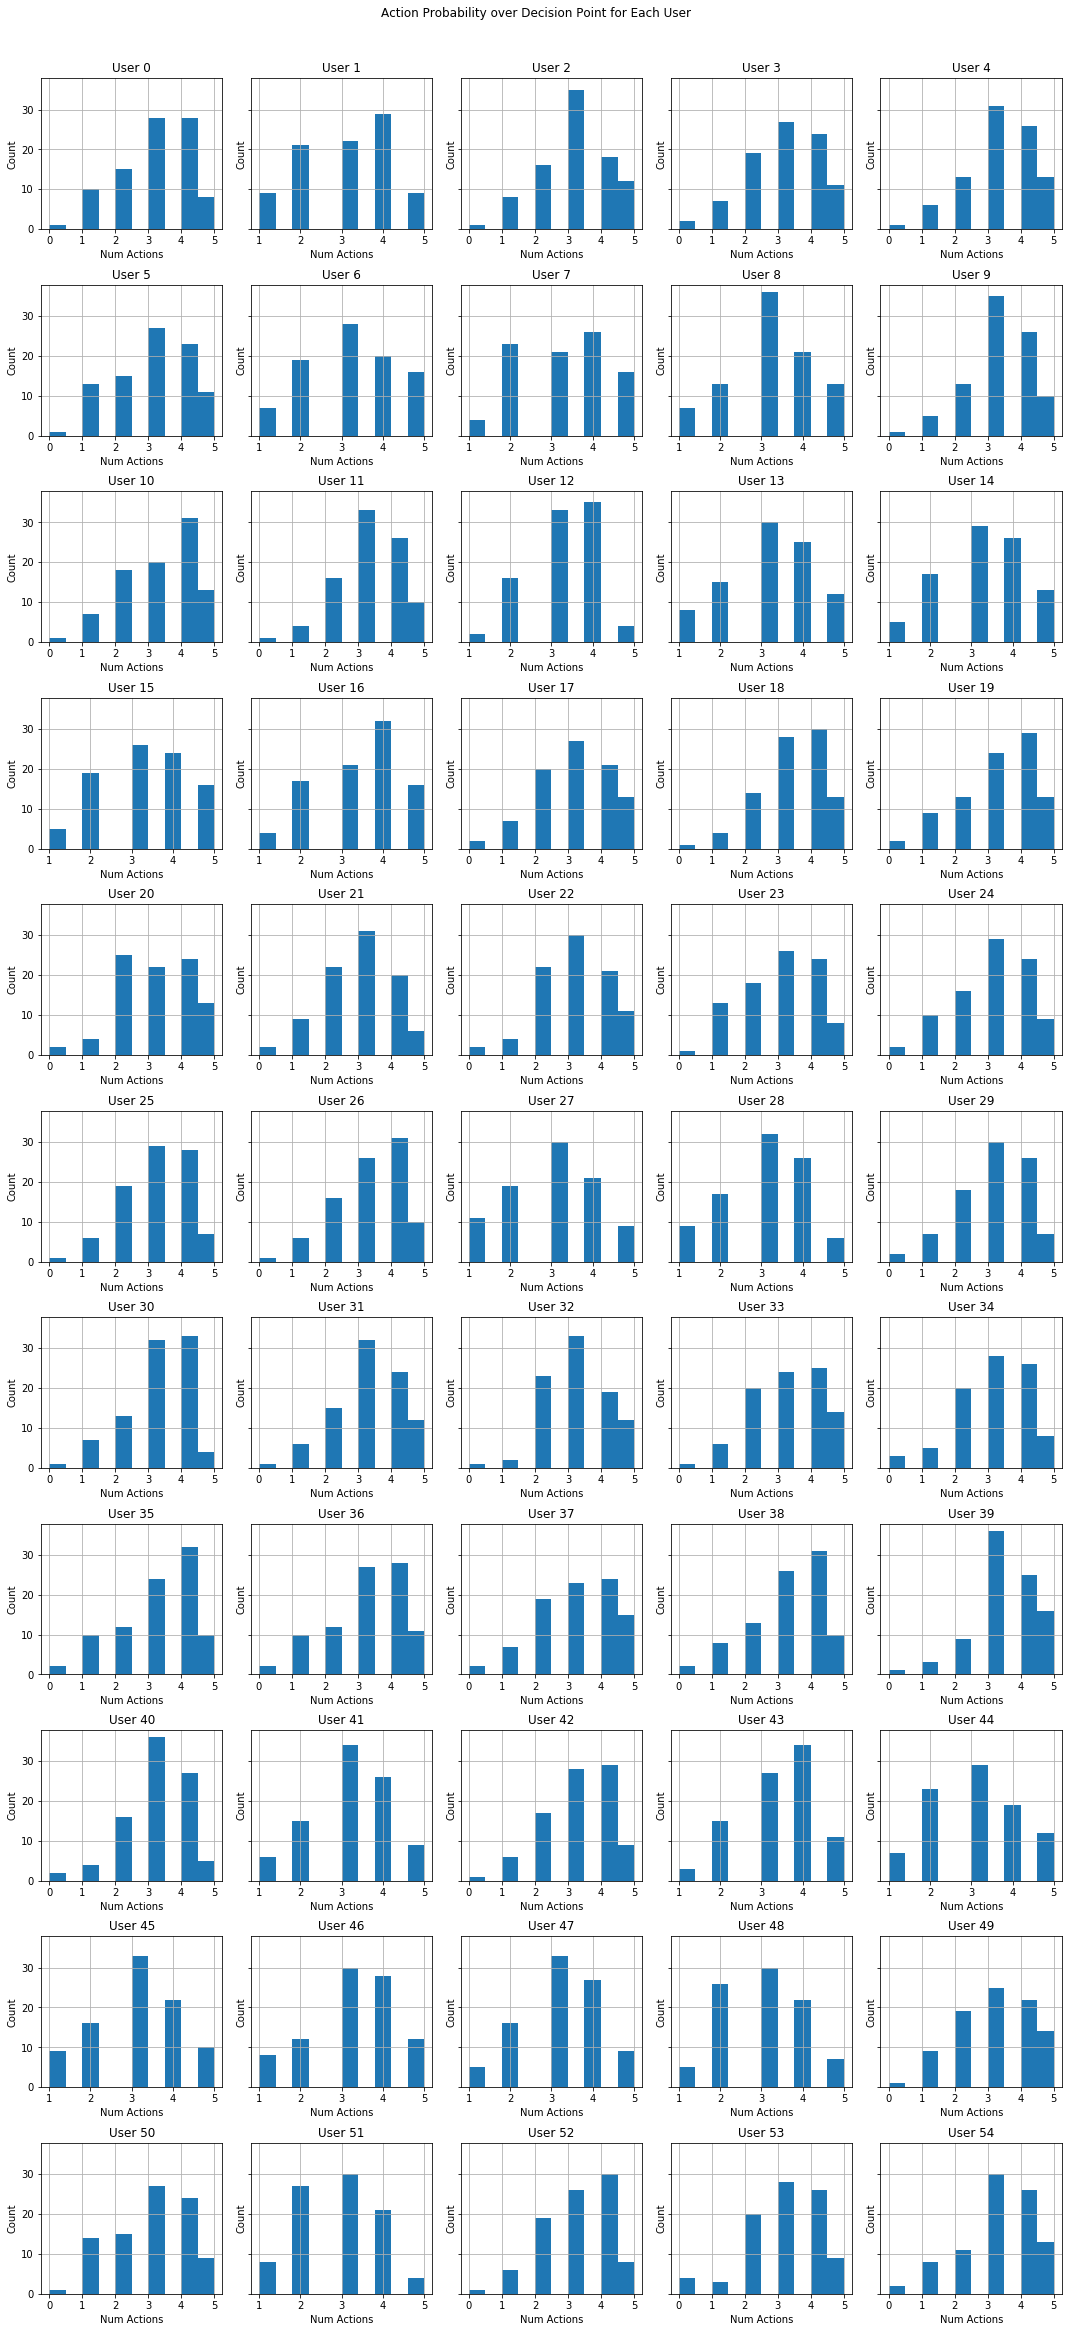

In [19]:
# QM 6a
def plot_QM6a(regret, prob, action, opt, y_size = 3, x_size = 15, hists_per_row = 5, alpha = 0.75):
    ''' Time Series of number of actions taken across all N users for all t
    '''
    N_new = prob.shape[0]
    num_plots = int(np.ceil(N_new/hists_per_row))
    fig,axes = plt.subplots(num_plots, hists_per_row, figsize = (x_size, y_size*num_plots), sharey=True)
    df_out = pd.DataFrame(np.sum(action.reshape((N_new, T_new, t)),axis=-1).T)
    for i,ax in zip(range(N_new),axes.flatten()):
        df_out.loc[:,i].hist(ax = ax, bins = t+t)
        ax.set_title("User " + str(i))
        ax.set_ylabel('Count')
        ax.set_xlabel('Num Actions')
        
        
    st = fig.suptitle("Action Probability over Decision Point for Each User")
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
        
        
plot_QM6a(regret, prob, action, opt)

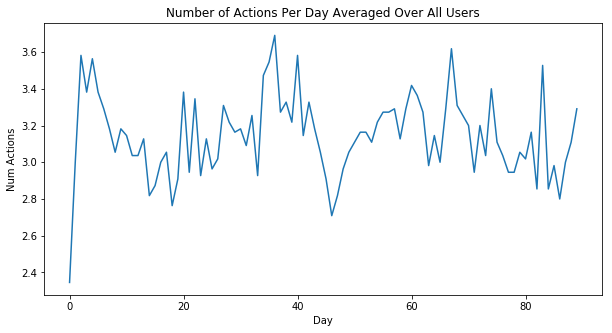

In [14]:
# QM 6b
def plot_QM6b(regret, prob, action, opt, y_size = 5, x_size = 10, num_show = 4, alpha = 0.75):
    ''' Time Series of number of actions per day taken across all N users for all t
    '''
    fig,ax = plt.subplots(1, 1, figsize = (x_size, y_size))
    pd.DataFrame(np.mean(np.sum(action.reshape((N_new, T_new, t)),axis=-1),axis=0)).plot(ax = ax, legend = False)
    ax.set_title('Number of Actions Per Day Averaged Over All Users')
    ax.set_ylabel('Num Actions')
    ax.set_xlabel('Day')
        
        
plot_QM6b(regret, prob, action, opt)

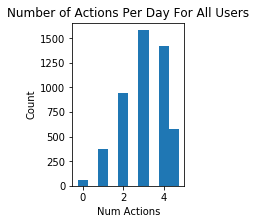

In [18]:
# QM 6c
def plot_QM6c(regret, prob, action, opt, y_size = 3, x_size = 5):
    ''' Time Series of number of actions taken across all N users for all t
    '''
    fig,ax = plt.subplots(1, 1, figsize = (x_size, y_size))
    ax.hist((np.sum(action.reshape((N_new, T_new, t)),axis=-1)).flatten(),align='left')
    ax.set_title('Number of Actions Per Day For All Users')
    ax.set_ylabel('Count')
    ax.set_xlabel('Num Actions')
        
plot_QM6c(regret, prob, action, opt)

# (Preliminary Testing)

In [24]:
# TEST GAMMA
prior_mdl = model(np.zeros((nInteract+nBaseline,1)),np.eye(nInteract+nBaseline))
fc_params = [1., 5, 10]

regrets = []
probs = []
actions = []
bandit_covs = []
bandi_means = []
gammas = [0.01,0.1,0.2,0.3,0.5,0.6,0.7,0.8,0.9,0.95,0.99,1.]
for gamma in gammas:
    print(gamma)
    regret, prob, action, bandit_cov, bandit_mean, bandit = run_simulation(coef0 = Etas_fit[3:11], coef1 = Etas_fit[0:3], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, reward_func = reward_func, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma)
    regrets.append(regret)
    probs.append(prob)
    actions.append(action)
    bandit_covs.append(bandit_cov)
    bandit_means.append(bandit_mean)

0.01
0.1
0.2
0.3
0.5
0.6
0.7
0.8
0.9
0.95
0.99
1.0


In [39]:
for i in range(len(regrets)):
    np.save('results/regrets' + str(i) +'.npy',regrets[i])
    np.save('results/probs' + str(i) +'.npy',probs[i])
    np.save('results/actions' + str(i) +'.npy',actions[i])
#     np.save('results/bandit_covs' + str(i) +'.npy',bandit_covs[i])
    np.save('results/bandit_means' + str(i) +'.npy',bandit_means[i])
    

In [58]:
regret_results = []
prob_results = []
action_results = []
bandit_cov_results = []
bandit_mean_results = []


for i in range(900):
    regret_results.append(np.load("results/regrets" + str(i) + '.npy'))
    prob_results.append(np.load("results/probs" + str(i) + '.npy'))
    action_results.append(np.load("results/actions" + str(i) + '.npy'))
    bandit_cov_results.append(np.load("results/bandit_covs" + str(i) + '.npy'))
    bandit_mean_results.append(np.load("results/bandit_means" + str(i) + '.npy'))

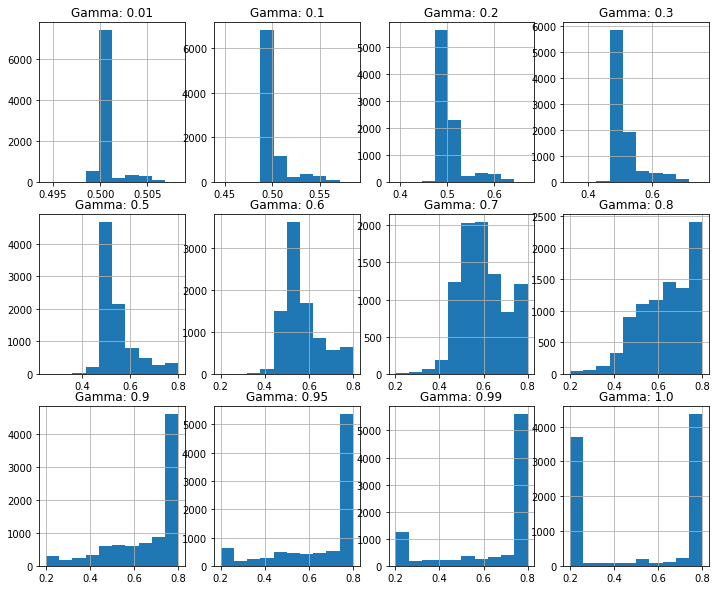

In [43]:
fig,axes = plt.subplots(3,4,figsize = (12,10))
for prob,ax,gamma in zip(probs,axes.flat,gammas):
#     fig,ax = plt.subplots()
    pd.Series(prob.flatten()).hist(ax = ax)
    ax.set_title("Gamma: "+ str(gamma))

In [133]:
# TEST All
prior_mdl = model(np.zeros((nInteract+nBaseline,1)),np.eye(nInteract+nBaseline))


regrets = []
probs = []
actions = []
bandit_covs = []
bandit_means = []

sigmas = [0.10, 0.50, 1.,2., 5, 10]
gammas = [0.1,0.5,0.7,0.8,0.9,0.99]
lambdas = [0.25, 0.5, 0.75, 1.,]
N_c_mults = [0.25, 0.5, 0.75]
T_cs = [5, 10, 20, 35, 50, 70]
T_cs_new = [30, 90,120,140,180,210,420,630]
for sigma in sigmas:
    for gamma in gammas:
        for lamb in lambdas:
            for N_c_mult in N_c_mults:
                for T_c in T_cs:
                    print(sigma, gamma, lamb, N_c_mult, T_c)
                    fc_params = [lamb, int(N_c_mult*T_c), T_c]
                    regret, prob, action, bandit_cov, bandit_mean, bandit = run_simulation(coef0 = Etas_fit[3:11], coef1 = Etas_fit[0:3], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, reward_func = reward, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2=sigma)
                    regrets.append(regret)
                    probs.append(prob)
                    actions.append(action)
                    bandit_covs.append(bandit_cov)
                    bandit_means.append(bandit_mean)

0.1 0.1 0.25 0.25 5
0.1 0.1 0.25 0.25 10
0.1 0.1 0.25 0.25 20
0.1 0.1 0.25 0.25 35
0.1 0.1 0.25 0.25 50
0.1 0.1 0.25 0.25 70
0.1 0.1 0.25 0.5 5
0.1 0.1 0.25 0.5 10
0.1 0.1 0.25 0.5 20
0.1 0.1 0.25 0.5 35
0.1 0.1 0.25 0.5 50
0.1 0.1 0.25 0.5 70
0.1 0.1 0.25 0.75 5
0.1 0.1 0.25 0.75 10
0.1 0.1 0.25 0.75 20
0.1 0.1 0.25 0.75 35
0.1 0.1 0.25 0.75 50
0.1 0.1 0.25 0.75 70
0.1 0.1 0.5 0.25 5
0.1 0.1 0.5 0.25 10
0.1 0.1 0.5 0.25 20
0.1 0.1 0.5 0.25 35
0.1 0.1 0.5 0.25 50
0.1 0.1 0.5 0.25 70
0.1 0.1 0.5 0.5 5
0.1 0.1 0.5 0.5 10
0.1 0.1 0.5 0.5 20
0.1 0.1 0.5 0.5 35
0.1 0.1 0.5 0.5 50
0.1 0.1 0.5 0.5 70
0.1 0.1 0.5 0.75 5
0.1 0.1 0.5 0.75 10
0.1 0.1 0.5 0.75 20
0.1 0.1 0.5 0.75 35
0.1 0.1 0.5 0.75 50
0.1 0.1 0.5 0.75 70
0.1 0.1 0.75 0.25 5
0.1 0.1 0.75 0.25 10
0.1 0.1 0.75 0.25 20
0.1 0.1 0.75 0.25 35
0.1 0.1 0.75 0.25 50
0.1 0.1 0.75 0.25 70
0.1 0.1 0.75 0.5 5
0.1 0.1 0.75 0.5 10
0.1 0.1 0.75 0.5 20
0.1 0.1 0.75 0.5 35
0.1 0.1 0.75 0.5 50
0.1 0.1 0.75 0.5 70
0.1 0.1 0.75 0.75 5
0.1 0.1 0.75 0.7

0.1 0.99 0.75 0.75 5
0.1 0.99 0.75 0.75 10
0.1 0.99 0.75 0.75 20
0.1 0.99 0.75 0.75 35
0.1 0.99 0.75 0.75 50
0.1 0.99 0.75 0.75 70
0.1 0.99 1.0 0.25 5
0.1 0.99 1.0 0.25 10
0.1 0.99 1.0 0.25 20
0.1 0.99 1.0 0.25 35
0.1 0.99 1.0 0.25 50
0.1 0.99 1.0 0.25 70
0.1 0.99 1.0 0.5 5
0.1 0.99 1.0 0.5 10
0.1 0.99 1.0 0.5 20
0.1 0.99 1.0 0.5 35
0.1 0.99 1.0 0.5 50
0.1 0.99 1.0 0.5 70
0.1 0.99 1.0 0.75 5
0.1 0.99 1.0 0.75 10
0.1 0.99 1.0 0.75 20
0.1 0.99 1.0 0.75 35
0.1 0.99 1.0 0.75 50
0.1 0.99 1.0 0.75 70
0.5 0.1 0.25 0.25 5
0.5 0.1 0.25 0.25 10
0.5 0.1 0.25 0.25 20
0.5 0.1 0.25 0.25 35
0.5 0.1 0.25 0.25 50
0.5 0.1 0.25 0.25 70
0.5 0.1 0.25 0.5 5
0.5 0.1 0.25 0.5 10
0.5 0.1 0.25 0.5 20
0.5 0.1 0.25 0.5 35
0.5 0.1 0.25 0.5 50
0.5 0.1 0.25 0.5 70
0.5 0.1 0.25 0.75 5
0.5 0.1 0.25 0.75 10
0.5 0.1 0.25 0.75 20
0.5 0.1 0.25 0.75 35
0.5 0.1 0.25 0.75 50
0.5 0.1 0.25 0.75 70
0.5 0.1 0.5 0.25 5
0.5 0.1 0.5 0.25 10
0.5 0.1 0.5 0.25 20
0.5 0.1 0.5 0.25 35
0.5 0.1 0.5 0.25 50
0.5 0.1 0.5 0.25 70
0.5 0.1 0.5 

0.5 0.99 0.5 0.5 5
0.5 0.99 0.5 0.5 10
0.5 0.99 0.5 0.5 20
0.5 0.99 0.5 0.5 35
0.5 0.99 0.5 0.5 50
0.5 0.99 0.5 0.5 70
0.5 0.99 0.5 0.75 5
0.5 0.99 0.5 0.75 10
0.5 0.99 0.5 0.75 20
0.5 0.99 0.5 0.75 35
0.5 0.99 0.5 0.75 50
0.5 0.99 0.5 0.75 70
0.5 0.99 0.75 0.25 5
0.5 0.99 0.75 0.25 10
0.5 0.99 0.75 0.25 20
0.5 0.99 0.75 0.25 35
0.5 0.99 0.75 0.25 50
0.5 0.99 0.75 0.25 70
0.5 0.99 0.75 0.5 5
0.5 0.99 0.75 0.5 10
0.5 0.99 0.75 0.5 20
0.5 0.99 0.75 0.5 35
0.5 0.99 0.75 0.5 50
0.5 0.99 0.75 0.5 70
0.5 0.99 0.75 0.75 5
0.5 0.99 0.75 0.75 10
0.5 0.99 0.75 0.75 20
0.5 0.99 0.75 0.75 35
0.5 0.99 0.75 0.75 50
0.5 0.99 0.75 0.75 70
0.5 0.99 1.0 0.25 5
0.5 0.99 1.0 0.25 10
0.5 0.99 1.0 0.25 20
0.5 0.99 1.0 0.25 35
0.5 0.99 1.0 0.25 50
0.5 0.99 1.0 0.25 70
0.5 0.99 1.0 0.5 5
0.5 0.99 1.0 0.5 10
0.5 0.99 1.0 0.5 20
0.5 0.99 1.0 0.5 35
0.5 0.99 1.0 0.5 50
0.5 0.99 1.0 0.5 70
0.5 0.99 1.0 0.75 5
0.5 0.99 1.0 0.75 10
0.5 0.99 1.0 0.75 20
0.5 0.99 1.0 0.75 35
0.5 0.99 1.0 0.75 50
0.5 0.99 1.0 0.75 70


1.0 0.99 0.25 0.25 5
1.0 0.99 0.25 0.25 10
1.0 0.99 0.25 0.25 20
1.0 0.99 0.25 0.25 35
1.0 0.99 0.25 0.25 50
1.0 0.99 0.25 0.25 70
1.0 0.99 0.25 0.5 5
1.0 0.99 0.25 0.5 10
1.0 0.99 0.25 0.5 20
1.0 0.99 0.25 0.5 35
1.0 0.99 0.25 0.5 50
1.0 0.99 0.25 0.5 70
1.0 0.99 0.25 0.75 5
1.0 0.99 0.25 0.75 10
1.0 0.99 0.25 0.75 20
1.0 0.99 0.25 0.75 35
1.0 0.99 0.25 0.75 50
1.0 0.99 0.25 0.75 70
1.0 0.99 0.5 0.25 5
1.0 0.99 0.5 0.25 10
1.0 0.99 0.5 0.25 20
1.0 0.99 0.5 0.25 35
1.0 0.99 0.5 0.25 50
1.0 0.99 0.5 0.25 70
1.0 0.99 0.5 0.5 5
1.0 0.99 0.5 0.5 10
1.0 0.99 0.5 0.5 20
1.0 0.99 0.5 0.5 35
1.0 0.99 0.5 0.5 50
1.0 0.99 0.5 0.5 70
1.0 0.99 0.5 0.75 5
1.0 0.99 0.5 0.75 10
1.0 0.99 0.5 0.75 20
1.0 0.99 0.5 0.75 35
1.0 0.99 0.5 0.75 50
1.0 0.99 0.5 0.75 70
1.0 0.99 0.75 0.25 5
1.0 0.99 0.75 0.25 10
1.0 0.99 0.75 0.25 20
1.0 0.99 0.75 0.25 35
1.0 0.99 0.75 0.25 50
1.0 0.99 0.75 0.25 70
1.0 0.99 0.75 0.5 5
1.0 0.99 0.75 0.5 10
1.0 0.99 0.75 0.5 20
1.0 0.99 0.75 0.5 35
1.0 0.99 0.75 0.5 50
1.0 0.99 

2.0 0.9 0.75 0.5 50
2.0 0.9 0.75 0.5 70
2.0 0.9 0.75 0.75 5
2.0 0.9 0.75 0.75 10
2.0 0.9 0.75 0.75 20
2.0 0.9 0.75 0.75 35
2.0 0.9 0.75 0.75 50
2.0 0.9 0.75 0.75 70
2.0 0.9 1.0 0.25 5
2.0 0.9 1.0 0.25 10
2.0 0.9 1.0 0.25 20
2.0 0.9 1.0 0.25 35
2.0 0.9 1.0 0.25 50
2.0 0.9 1.0 0.25 70
2.0 0.9 1.0 0.5 5
2.0 0.9 1.0 0.5 10
2.0 0.9 1.0 0.5 20
2.0 0.9 1.0 0.5 35
2.0 0.9 1.0 0.5 50
2.0 0.9 1.0 0.5 70
2.0 0.9 1.0 0.75 5
2.0 0.9 1.0 0.75 10
2.0 0.9 1.0 0.75 20
2.0 0.9 1.0 0.75 35
2.0 0.9 1.0 0.75 50
2.0 0.9 1.0 0.75 70
2.0 0.99 0.25 0.25 5
2.0 0.99 0.25 0.25 10
2.0 0.99 0.25 0.25 20
2.0 0.99 0.25 0.25 35
2.0 0.99 0.25 0.25 50
2.0 0.99 0.25 0.25 70
2.0 0.99 0.25 0.5 5
2.0 0.99 0.25 0.5 10
2.0 0.99 0.25 0.5 20
2.0 0.99 0.25 0.5 35
2.0 0.99 0.25 0.5 50
2.0 0.99 0.25 0.5 70
2.0 0.99 0.25 0.75 5
2.0 0.99 0.25 0.75 10
2.0 0.99 0.25 0.75 20
2.0 0.99 0.25 0.75 35
2.0 0.99 0.25 0.75 50
2.0 0.99 0.25 0.75 70
2.0 0.99 0.5 0.25 5
2.0 0.99 0.5 0.25 10
2.0 0.99 0.5 0.25 20
2.0 0.99 0.5 0.25 35
2.0 0.99 0.5 0

5 0.9 1.0 0.25 5
5 0.9 1.0 0.25 10
5 0.9 1.0 0.25 20
5 0.9 1.0 0.25 35
5 0.9 1.0 0.25 50
5 0.9 1.0 0.25 70
5 0.9 1.0 0.5 5
5 0.9 1.0 0.5 10
5 0.9 1.0 0.5 20
5 0.9 1.0 0.5 35
5 0.9 1.0 0.5 50
5 0.9 1.0 0.5 70
5 0.9 1.0 0.75 5
5 0.9 1.0 0.75 10
5 0.9 1.0 0.75 20
5 0.9 1.0 0.75 35
5 0.9 1.0 0.75 50
5 0.9 1.0 0.75 70
5 0.99 0.25 0.25 5
5 0.99 0.25 0.25 10
5 0.99 0.25 0.25 20
5 0.99 0.25 0.25 35
5 0.99 0.25 0.25 50
5 0.99 0.25 0.25 70
5 0.99 0.25 0.5 5
5 0.99 0.25 0.5 10
5 0.99 0.25 0.5 20
5 0.99 0.25 0.5 35
5 0.99 0.25 0.5 50
5 0.99 0.25 0.5 70
5 0.99 0.25 0.75 5
5 0.99 0.25 0.75 10
5 0.99 0.25 0.75 20
5 0.99 0.25 0.75 35
5 0.99 0.25 0.75 50
5 0.99 0.25 0.75 70
5 0.99 0.5 0.25 5
5 0.99 0.5 0.25 10
5 0.99 0.5 0.25 20
5 0.99 0.5 0.25 35
5 0.99 0.5 0.25 50
5 0.99 0.5 0.25 70
5 0.99 0.5 0.5 5
5 0.99 0.5 0.5 10
5 0.99 0.5 0.5 20
5 0.99 0.5 0.5 35
5 0.99 0.5 0.5 50
5 0.99 0.5 0.5 70
5 0.99 0.5 0.75 5
5 0.99 0.5 0.75 10
5 0.99 0.5 0.75 20
5 0.99 0.5 0.75 35
5 0.99 0.5 0.75 50
5 0.99 0.5 0.75 70
5

10 0.9 1.0 0.25 10
10 0.9 1.0 0.25 20
10 0.9 1.0 0.25 35
10 0.9 1.0 0.25 50
10 0.9 1.0 0.25 70
10 0.9 1.0 0.5 5
10 0.9 1.0 0.5 10
10 0.9 1.0 0.5 20
10 0.9 1.0 0.5 35
10 0.9 1.0 0.5 50
10 0.9 1.0 0.5 70
10 0.9 1.0 0.75 5
10 0.9 1.0 0.75 10
10 0.9 1.0 0.75 20
10 0.9 1.0 0.75 35
10 0.9 1.0 0.75 50
10 0.9 1.0 0.75 70
10 0.99 0.25 0.25 5
10 0.99 0.25 0.25 10
10 0.99 0.25 0.25 20
10 0.99 0.25 0.25 35
10 0.99 0.25 0.25 50
10 0.99 0.25 0.25 70
10 0.99 0.25 0.5 5
10 0.99 0.25 0.5 10
10 0.99 0.25 0.5 20
10 0.99 0.25 0.5 35
10 0.99 0.25 0.5 50
10 0.99 0.25 0.5 70
10 0.99 0.25 0.75 5
10 0.99 0.25 0.75 10
10 0.99 0.25 0.75 20
10 0.99 0.25 0.75 35
10 0.99 0.25 0.75 50
10 0.99 0.25 0.75 70
10 0.99 0.5 0.25 5
10 0.99 0.5 0.25 10
10 0.99 0.5 0.25 20
10 0.99 0.5 0.25 35
10 0.99 0.5 0.25 50
10 0.99 0.5 0.25 70
10 0.99 0.5 0.5 5
10 0.99 0.5 0.5 10
10 0.99 0.5 0.5 20
10 0.99 0.5 0.5 35
10 0.99 0.5 0.5 50
10 0.99 0.5 0.5 70
10 0.99 0.5 0.75 5
10 0.99 0.5 0.75 10
10 0.99 0.5 0.75 20
10 0.99 0.5 0.75 35
10 0.

In [135]:
for i in range(len(regrets)):
    np.save('results_new/regrets' + str(i) +'.npy',regrets[i])
    np.save('results_new/probs' + str(i) +'.npy',probs[i])
    np.save('results_new/actions' + str(i) +'.npy',actions[i])
    np.save('results_new/bandit_means' + str(i) +'.npy',bandit_means[i])
    

In [ ]:
for i in range(len(regrets)):
    np.save('results/regrets' + str(i) +'.npy',regrets[i])
    np.save('results/probs' + str(i) +'.npy',probs[i])
    np.save('results/actions' + str(i) +'.npy',actions[i])
#     np.save('results/bandit_covs' + str(i) +'.npy',bandit_covs[i])
    np.save('results/bandit_means' + str(i) +'.npy',bandit_means[i])
    

In [127]:

prior_mdl = model(np.zeros((nInteract+nBaseline,1)),np.eye(nInteract+nBaseline))
fc_params = [1., 5, 10]

In [ ]:
sigmas = [0.50, 0.75, 1.]
gammas = [0.1,0.5,0.7,0.8,0.9]
lambdas = [0.25, 0.5, 0.75, 1.]
N_c_mults = [0.25, 0.5, 0.75]
T_cs = [5, 10, 20, 35, 50, 70]

In [103]:
a,b,c,d,e = [],[],[],[],[]
for i in itertools.product(gammas, lambdas, N_c_mults, T_cs,sigmas):
    a.append(i[0])
    b.append(i[1])
    c.append(i[2])
    d.append(i[3])
    e.append(i[4])
    
indices = pd.DataFrame({"gamma":a, "lambda": b, "N_c_mult" : c, "T_c" : d,"sigma":e})

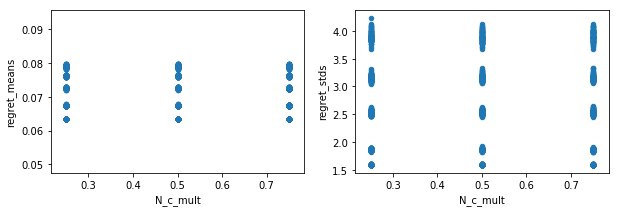

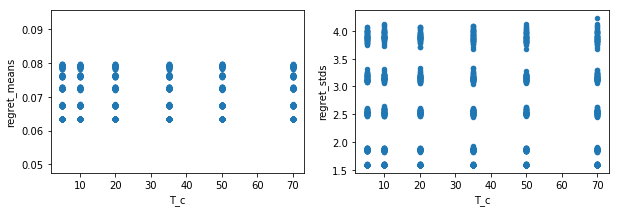

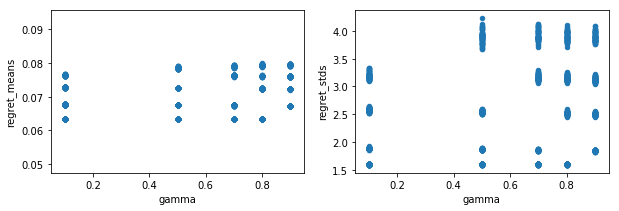

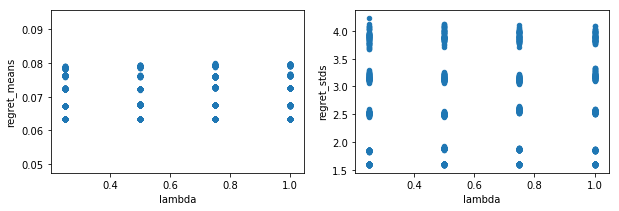

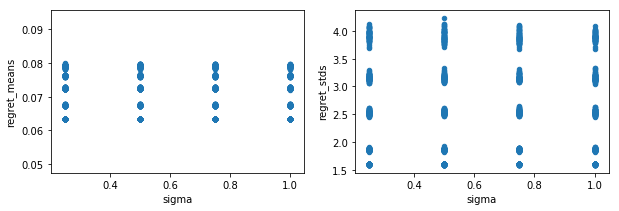

In [110]:
regret_results_means = [np.mean(regret) for regret in regrets]
regret_results_stds = [np.sum(regret,axis = 1).std() for regret in regrets]

# probs_results_means =[np.mean(probs) for regret in regret_results]
# probs_results_stds = [np.sum(regret,axis = 1).std() for regret in regret_results]


results = {'regret_means': regret_results_means, 'regret_stds': regret_results_stds}

a = plot_params_vs_results(results, indices)


In [111]:
a.shape

(1440, 7)

In [51]:
# Create indices


gammas = [0.1,0.5,0.7,0.8,0.9]
lambdas = [0.1, 0.25, 0.5, 0.75, 1., 10.]
N_c_mults = [0.1, 0.25, 0.5, 0.75, 0.9]
T_cs = [5, 10, 20, 35, 50, 70]
T_cs_new = [30, 90,120,140,180,210,420,630]

a,b,c,d = [],[],[],[]
for i in itertools.product(gammas, lambdas, N_c_mults, T_cs):
    a.append(i[0])
    b.append(i[1])
    c.append(i[2])
    d.append(i[3])

indices = pd.DataFrame({"gamma":a, "lambda": b, "N_c_mult" : c, "T_c" : d})

In [107]:
def plot_params_vs_results(results, indices, figsize = (10,3)):
    results_df = pd.DataFrame(results)
    df_cat = pd.concat([indices, results_df], axis=1)

    cols = list(results.keys())
    param_names = indices.columns


    for param in param_names:
        fig, ax = plt.subplots(1,len(cols), figsize = figsize)
        for i,col in zip(range(len(cols)), cols):
            df_cat.plot(kind = 'scatter', x = param, y = col, ax = ax[i])
    
    return df_cat

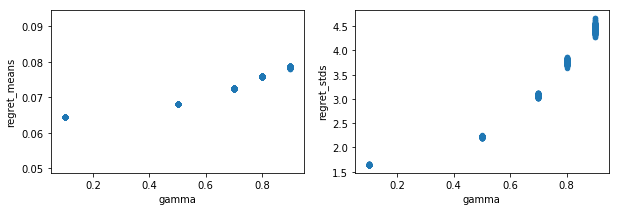

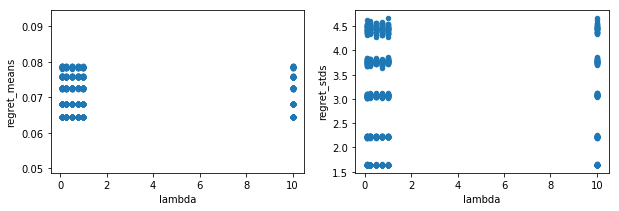

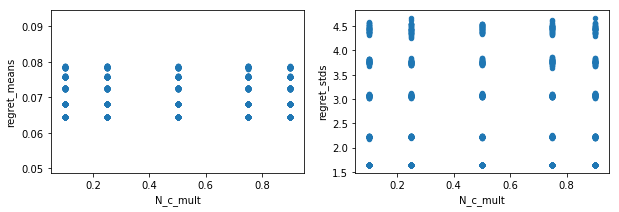

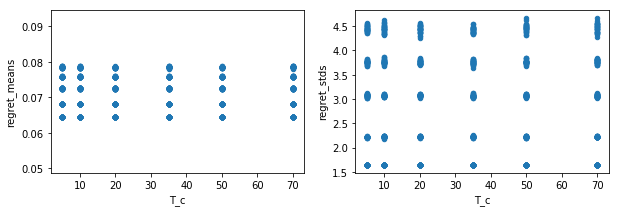

In [92]:
regret_results_means = [np.mean(regret) for regret in regret_results]
regret_results_stds = [np.sum(regret,axis = 1).std() for regret in regret_results]


results = {'regret_means': regret_results_means, 'regret_stds': regret_results_stds}

_ = plot_params_vs_results(results, indices)


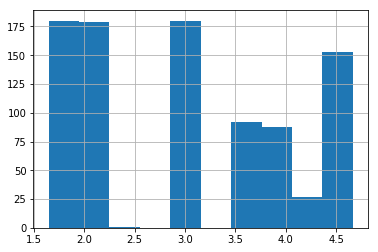

In [20]:
pd.Series(regret_results_stds).hist()

In [11]:
np.sum(regret_results[0],axis=1).mean()

29.045307368192784

In [11]:
bandit_means[:,-1,:].mean(axis=0)

array([ 3.10865709, -0.08888395,  0.10159862,  0.27720841,  1.22102856,
        0.35033489,  0.11793383,  0.26297994, -0.25819153, -0.02495706,
        0.15896695])

In [12]:
Etas_fit

array([-0.21181203, -0.16692167,  0.08116949,  3.04487594, -0.02305797,
        0.06443497,  0.18900795,  1.36208089,  0.30135504,  0.23107337,
        0.38301622])

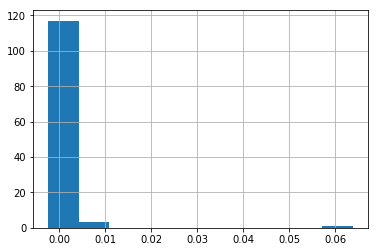

In [13]:
i = 14
pd.Series(bandit_covs[0][i*30].flatten()).hist()

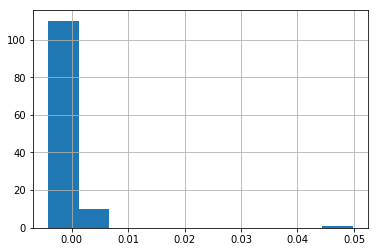

In [16]:
pd.Series(bandit.current_model.Sigma.flatten()).hist()

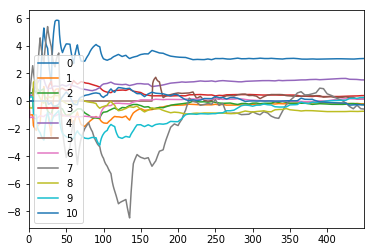

In [17]:
pd.DataFrame(bandit_means[0]).plot()

C:\Users\isaac\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


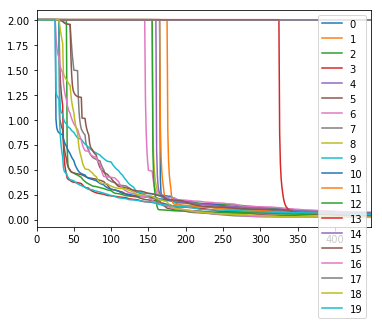

In [18]:
eigs = np.empty((N_new, T_new*t, 11))
for n in range(N_new):
    for time in range(T_new*t):
        eigs[n, time] = np.linalg.eigvals(bandit_covs[n, time])
pd.DataFrame(np.max(eigs,axis = -1)).T.plot()

In [ ]:
# Todo:

# Understand algorithm (Current Bandit, simulation data, generative model, tuning parameters etc)
# Future: How to generate data where features are based on prior actions?

# See difference between 1 user and averaged N>1 users

# First step: understand impact of \alpha based on quality metrics